In [1]:
import sys, os
import numpy as np

from pygama.dsp.ProcessingChain import ProcessingChain
from pygama.dsp.processors import *
from pygama.dsp.units import *

from pygama.io import io_base as io

# CONSTANT VARIABLES TO SET UP CONFIG
filename = os.path.expandvars('$DATADIR/CAGE/pygama_raw/raw_run42.lh5')
groupname = "ORSIS3302DecoderForEnergy"
verbosity = 2
wfblock = 8

In [38]:
# Set up file I/O
lh5 = io.LH5Store()
data = lh5.read_object(groupname, filename, start_row=0, n_rows=1000)

wf_in = data['waveform']['values'].nda
dt = data['waveform']['dt'].nda[0] * unit_parser.parse_unit(data['waveform']['dt'].attrs['units'])

# Parameters for DCR calculation
dcr_trap_int = 200
dcr_trap_flat = 1000
dcr_trap_startSample = 1200

# Set up processing chain
proc = ProcessingChain(block_width=wfblock, clock_unit=dt, verbosity=verbosity)
proc.add_input_buffer("wf", wf_in, dtype='float32')
proc.add_processor(mean_stdev, "wf[0:1000]", "bl", "bl_sig")
proc.add_processor(np.subtract, "wf", "bl", "wf_blsub")
proc.add_processor(pole_zero, "wf_blsub", 70*us, "wf_pz")
proc.add_processor(trap_norm, "wf_pz", 10*us, 10*us, "wf_trap")

#calculation of DCR using trap_norm. Calculates full trapezoidal filter, fixed time pickoff to choose DCR value
proc.add_processor(trap_norm, "wf_pz", dcr_trap_int, dcr_trap_flat, "dcr_trap")
proc.add_processor(np.argmax, "wf_blsub", -1, "dcr_trap_max_sample", signature='(n),()->()', types=['fi->i'])
proc.add_processor(fixed_time_pickoff, "dcr_trap", "dcr_trap_max_sample",dcr_trap_startSample, "dcr")

#calculation of DCR using trap_pickoff. Equivalent to method with trap_norm, but only calculates portion of the trap relevent for DCR
proc.add_processor(trap_pickoff, "wf_pz", dcr_trap_int, dcr_trap_flat, dcr_trap_startSample, "dcr_new")


Setting i/o buffer length to 1000
Added variable wf with shape (8, 3000) and type float32
Binding input buffer of shape (1000, 3000) and type uint16 to variable wf with shape (8, 3000) and type float32
Added variable bl with shape (8,) and type float32
Added variable bl_sig with shape (8,) and type float32
Added processor: mean_stdev(wf, bl, bl_sig)
Added variable wf_blsub with shape (8, 3000) and type float32
Added processor: subtract(wf, bl, wf_blsub)
Added variable wf_pz with shape (8, 3000) and type float32
Added processor: pole_zero(wf_blsub, 7000.0, wf_pz)
Added variable wf_trap with shape (8, 3000) and type float32
Added processor: trap_norm(wf_pz, 1000, 1000, wf_trap)
Added variable dcr_trap with shape (8, 3000) and type float32
Added processor: trap_norm(wf_pz, 200, 1000, dcr_trap)
Added variable dcr_trap_max_sample with shape (8,) and type int32
Added processor: argmax(wf_blsub, -1, dcr_trap_max_sample)
Added variable dcr with shape (8,) and type float32
Added processor: fixe

In [39]:
# Get the outputs of interest
wf = proc.get_output_buffer("wf_blsub")
trap = proc.get_output_buffer("wf_trap")
wfindex = np.arange(trap.shape[-1])
wf_pz = proc.get_output_buffer("wf_pz")
wf_trap = proc.get_output_buffer("wf_trap")

dcr_trap = proc.get_output_buffer("dcr_trap")
dcr_trap_max_sample = proc.get_output_buffer("dcr_trap_max_sample")
dcr_index = np.arange(dcr_trap.shape[-1])

dcr_new = proc.get_output_buffer("dcr_new")


# Execute analysis
proc.execute()


Binding output buffer of shape (1000, 3000) and type float32 to variable wf_blsub with shape (8, 3000) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable wf_trap with shape (8, 3000) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable wf_pz with shape (8, 3000) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable dcr_trap with shape (8, 3000) and type float32
Binding output buffer of shape (1000,) and type int32 to variable dcr_trap_max_sample with shape (8,) and type int32
Binding output buffer of shape (1000,) and type float32 to variable dcr_new with shape (8,) and type float32


In [40]:
# Set index counter. Rerun this box to start over the file...
wfnum = 0

-0.037809145
-13.809555


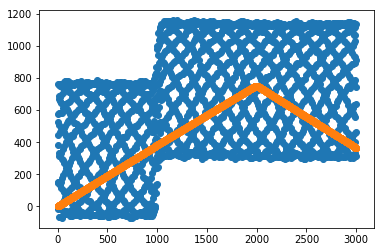

In [42]:
import matplotlib.pyplot as plt

print(dcr_trap[wfnum][-1])
print(dcr_new[wfnum])

# Draw things!
plt.scatter(wfindex, wf_pz[wfnum])
plt.scatter(wfindex, wf_trap[wfnum])
# plt.scatter(dcr_index, dcr_trap[wfnum])
# plt.hlines(dcr_trap[wfnum][-1], 0, np.argmax(wf_pz[wfnum]), colors='red')
# plt.hlines(dcr_new[wfnum], dcr_trap_startSample, len(wf_pz[wfnum]))

plt.show();
wfnum+=1